## AC209b: Data Science 2 - Advanced Topics in Data Science
### Final Project: <br>Deep Learning for Image Sequence Classification of Astronomical Events

Group 7: Ziqi Guo, Xuefeng Peng, Jiacheng Shi, Weihang Zhang<br>
Harvard University, Spring 2018

---

In [28]:
import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, \
    Flatten, Lambda, LSTM, RepeatVector, TimeDistributed, Reshape, \
    Conv2D, MaxPooling2D, BatchNormalization, ConvLSTM2D, Bidirectional, Masking
import keras.callbacks as Callbacks
from keras.callbacks import ModelCheckpoint
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import scale
from matplotlib import pyplot as plt
from skimage.util import random_noise
from skimage.transform import rotate
from scipy import ndimage
import seaborn as sns
import json
% matplotlib inline

### Define Utility Functions

In [36]:
def scale_images(images):
    t_images = np.transpose(images, (0,3,1,2))
    rt_images = t_images.reshape(72000*48, 21, 21)
    max_per_img = np.max(rt_images.reshape(-1, 21*21), axis=1, keepdims=1)
    scaled_images = rt_images.reshape(-1, 21*21) / max_per_img
    scaled_images = scaled_images.reshape(-1, 21, 21).reshape(-1, 48, 21, 21)
    return scaled_images

def augment_data(images, percent=0.25):
    size, timestep, _, _ = images.shape
    sample_size = int(size * percent)
    
    np.random.seed(209)
    # pick the sequence with replacement
    sample_seq_indices = np.random.choice(np.arange(sample_size), sample_size)
    # pick the timestep
    sample_inseq_indices = np.random.choice(np.arange(timestep), sample_size)
    # pick the aug mean
    sample_aug_type = np.random.choice(np.arange(4), sample_size)
    
    for idx in range(sample_size):
        i, j, k = sample_seq_indices[idx], \
            sample_inseq_indices[idx], sample_aug_type[idx]
        if k == 0: # rotate
            images[i, j] = rotate(images[i, j], 45)
        elif k == 1: # random noise
            images[i, j] = random_noise(images[i, j], seed=209)
        elif k == 2: # horizontal flip
            images[i, j] = images[i, j][:,::-1]
        else: # vertical flip
            images[i, j] = images[i, j][::-1,:]
            
def txt2digit(labels):
    dic = {'Asteroids':0, 'Constant':1, 'EmptyLigh':2, 'M33Cephei':3, 'RRLyrae':4, 'Supernova':5}
    labels_digit = np.array([dic[i] for i in labels])
    return labels_digit


def build_dataset(images, labels, augment=False):
    scaled_img = scale_images(images)
    if augment:
        augment_data(scaled_img)
    x = np.expand_dims(scaled_img, len(scaled_img.shape))
    y = to_categorical(txt2digit(labels))
    return x, y

def compute_confusion_matrix(model, x, y):
    from sklearn.metrics import confusion_matrix
    pred = model.predict_classes(x)
    labels = y @ np.array([0,1,2,3,4,5]).T
    cm = confusion_matrix(labels, pred)
    return cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    plt.figure(figsize=(6,6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.grid(False)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Data Loading and Preprocessing
We need to prepare data in slightly different ways for CNN and RCNN data.

In [21]:
data = h5py.File("../dataset/data_sample.hdf5", "r")
images = data["images"][:]
labels = data["labels"][:]


x, y = build_dataset(images, labels)
x_scaled, y = build_dataset(scale_images(images), labels)
# Use different format for CNN data
x_cnn = x.reshape(x.shape[:-1]).transpose([0,2,3,1])

# Train test split for CNN and RCNN
x_train_cnn, x_test_cnn, y_train, y_test = train_test_split(x_cnn, y, test_size=0.2, random_state=209, stratify=y)
x_train_rcnn, x_test_rcnn, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=209, stratify=y)
x_train_rcnn2, x_test_rcnn2, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=209, stratify=y)
print('CNN data shape: ', x_train_cnn.shape)
print('RCNN data shape: ', x_train_rcnn.shape)

CNN data shape:  (57600, 21, 48, 21)
RCNN data shape:  (57600, 48, 21, 21, 1)


### Build Convolutional Neural Networks

In [8]:
def init_cnn():
    model = Sequential()
    
    model.add(Conv2D(48, (4,4), input_shape=(21,21,48), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(MaxPooling2D((3,3), strides=(1,1)))
    
    model.add(Conv2D(24, (3,3), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(MaxPooling2D((3,3), strides=(1,1)))

    model.add(Conv2D(12, (3,3), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(MaxPooling2D((3,3), strides=(1,1)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(6, activation='softmax'))

    return model

In [9]:
mod_cnn = init_cnn()
print(mod_cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 21, 21, 48)        36912     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 24)        10392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 12)        2604      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 12)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2700)              0         
__________

In [ ]:
adam = keras.optimizers.Adam(lr=0.0001)
mod_cnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='saved_models/cnn.hdf5', verbose=1, save_best_only=True)

# history = model.fit(x_train, y_train,
#                     batch_size=100,
#                     epochs=200,
#                     validation_data=[x_test_cnn,y_test],
#                     callbacks=[checkpointer],
#                     shuffle=True)

For demonstration, we directly load from a pre-trained model.

In [16]:
mod_cnn = keras.models.load_model('saved_models/cnn_ep200.hdf5')
print('Test accuracy: ', mod_cnn.evaluate(x_test_cnn, y_test)[1])

14400/14400 [==============================] - 23s 2ms/step
Test accuracy:  0.8172916666666666


We load from the saved history file to plot learning curves.

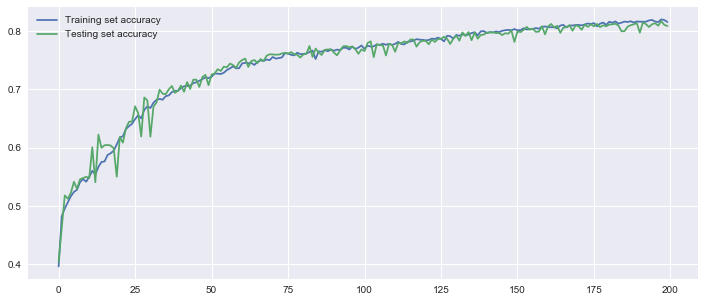

In [19]:
with open('saved_history/cnn_ep200.json') as json_data:
    hist_cnn = json.load(json_data)

plt.figure(figsize=(12,5))
plt.plot(hist_cnn['acc'], label='Training set accuracy')
plt.plot(hist_cnn['val_acc'], label='Testing set accuracy')
plt.legend()

Confusion matrix, without normalization


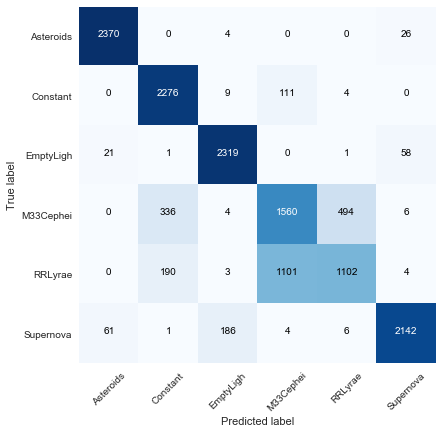

In [20]:
cm_cnn = compute_confusion_matrix(mod_cnn, x_test_cnn, y_test)
plot_confusion_matrix(cm_cnn, classes=['Asteroids', 'Constant', 'EmptyLigh', 'M33Cephei', 'RRLyrae', 'Supernova'])

### Build Recurrent Convolutional Neural Networks

In [45]:
def init_rcnn(bidir, batch_norm, cnn_input_dim=21, cnn_output_dim=128, cnn_dropout=0.25,
              rnn_hidden_dim=128, num_classes=6, rnn_dropout=0.5, timestep=48,
              bidir_mode='concat'):
    
    input_shape = (timestep, cnn_input_dim, cnn_input_dim, 1, )
    
    model = Sequential()
    
    model.add(TimeDistributed(Masking(), input_shape=input_shape, name='Masking'))
    model.add(TimeDistributed(Conv2D(48, (4,4), \
                     padding='same', activation='relu', kernel_initializer='uniform'), \
                              input_shape=input_shape, name='Conv2D_1'))
    model.add(TimeDistributed(MaxPooling2D((3,3), strides=(1,1)), name='MaxPooling2D_1'))
    
    model.add(TimeDistributed(Conv2D(24, (3,3), padding='same', activation='relu', kernel_initializer='uniform'),\
                 name='Conv2D_2'))
    model.add(TimeDistributed(MaxPooling2D((3,3), strides=(1,1)), name='MaxPooling2D_2'))

    model.add(TimeDistributed(Conv2D(12, (3,3), padding='same', activation='relu', kernel_initializer='uniform'), \
                             name='Conv2D_3'))
    
    if batch_norm:
        model.add(TimeDistributed(BatchNormalization(momentum=0.3), name='BatchNorm'))

    model.add(TimeDistributed(MaxPooling2D((3,3), strides=(1,1)), name='MaxPooling2D_3'))
    
    model.add(TimeDistributed(Flatten(), name='Flatten'))

    model.add(TimeDistributed(Dense(cnn_output_dim, activation='relu'), name='Dense'))
    model.add(Dropout(cnn_dropout))
    
    if bidir:
        model.add(Bidirectional(LSTM(rnn_hidden_dim, dropout=rnn_dropout, return_sequences=True), \
                                merge_mode=bidir_mode, name='LSTM_1'))
        model.add(Bidirectional(LSTM(rnn_hidden_dim, dropout=rnn_dropout), merge_mode=bidir_mode, name='LSTM_2'))
    else:
        model.add(LSTM(rnn_hidden_dim, dropout=rnn_dropout, return_sequences=True, name='LSTM_1'))
        model.add(LSTM(rnn_hidden_dim, dropout=rnn_dropout, name='LSTM_2'))
        
    model.add(Dense(6, activation='softmax', name='Output_Dense'))
    
    return model

#### Version 1: Unidirectional LSTM

In [25]:
mod_rcnn_1 = init_rcnn(bidir=False)
mod_rcnn_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Masking (TimeDistributed)    (None, 48, 21, 21, 1)     0         
_________________________________________________________________
Conv2D_1 (TimeDistributed)   (None, 48, 21, 21, 48)    816       
_________________________________________________________________
MaxPooling2D_1 (TimeDistribu (None, 48, 19, 19, 48)    0         
_________________________________________________________________
Conv2D_2 (TimeDistributed)   (None, 48, 19, 19, 24)    10392     
_________________________________________________________________
MaxPooling2D_2 (TimeDistribu (None, 48, 17, 17, 24)    0         
_________________________________________________________________
Conv2D_3 (TimeDistributed)   (None, 48, 17, 17, 12)    2604      
_________________________________________________________________
MaxPooling2D_3 (TimeDistribu (None, 48, 15, 15, 12)    0         
__________

In [26]:
adam = keras.optimizers.Adam(lr=0.0001)
mod_cnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='saved_models/cnn.hdf5', verbose=1, save_best_only=True)

# history = model.fit(x_train, y_train,
#                     batch_size=100,
#                     epochs=200,
#                     validation_data=[x_test_cnn,y_test],
#                     callbacks=[checkpointer],
#                     shuffle=True)

In [29]:
mod_rcnn_1 = keras.models.load_model('saved_models/rcnn_simple_ep300.hdf5')
print('Test accuracy: ', mod_rcnn_1.evaluate(x_test_rcnn2, y_test)[1])

TypeError: ('Keyword argument not understood:', 'data_format')

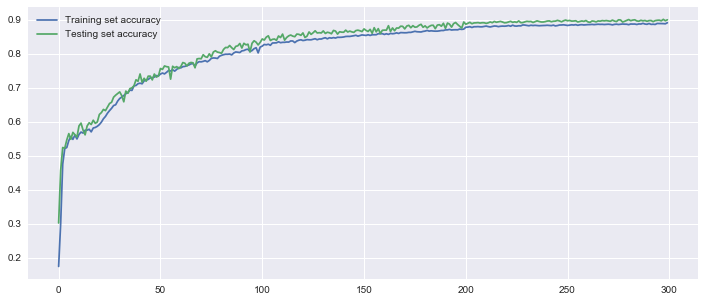

In [31]:
with open('saved_history/simple_lstm_ep300/history.json', 'r') as f:
    hist_ep100 = json.load(f)
with open('saved_history/simple_lstm_ep300/history1.json', 'r') as f:
    hist_ep200 = json.load(f)
with open('saved_history/simple_lstm_ep300/history2.json', 'r') as f:
    hist_ep300 = json.load(f)
    
plt.figure(figsize=(12,5))
plt.plot(range(len(hist_ep100['acc']+hist_ep200['acc']+hist_ep300['acc'])),\
         hist_ep100['acc']+hist_ep200['acc']+hist_ep300['acc'], label='Training set accuracy')
plt.plot(range(len(hist_ep100['acc']+hist_ep200['acc']+hist_ep300['acc'])), \
         hist_ep100['val_acc']+hist_ep200['val_acc']+hist_ep300['val_acc'], label='Testing set accuracy')
plt.legend()
plt.show()

In [ ]:
cm_rcnn_1 = compute_confusion_matrix(mod_rcnn_1, x_test_rcnn2, y_test)
plot_confusion_matrix(cm_rcnn_1, classes=['Asteroids', 'Constant', 'EmptyLigh', 'M33Cephei', 'RRLyrae', 'Supernova'])

#### Version 2: Bidirectional LSTM

In [32]:
mod_rcnn_2 = init_rcnn(bidir=True)
mod_rcnn_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Masking (TimeDistributed)    (None, 48, 21, 21, 1)     0         
_________________________________________________________________
Conv2D_1 (TimeDistributed)   (None, 48, 21, 21, 48)    816       
_________________________________________________________________
MaxPooling2D_1 (TimeDistribu (None, 48, 19, 19, 48)    0         
_________________________________________________________________
Conv2D_2 (TimeDistributed)   (None, 48, 19, 19, 24)    10392     
_________________________________________________________________
MaxPooling2D_2 (TimeDistribu (None, 48, 17, 17, 24)    0         
_________________________________________________________________
Conv2D_3 (TimeDistributed)   (None, 48, 17, 17, 12)    2604      
_________________________________________________________________
MaxPooling2D_3 (TimeDistribu (None, 48, 15, 15, 12)    0         
__________

In [ ]:
mod_rcnn_2 = keras.models.load_model('saved_models/rcnn_ep200.hdf5')
print('Test accuracy: ', mod_rcnn_2.evaluate(x_test_rcnn, y_test)[1])

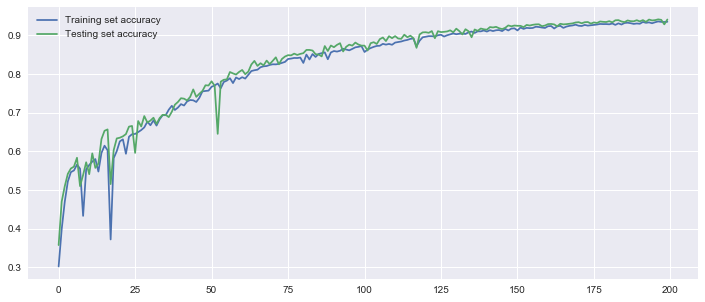

In [34]:
with open('saved_history/rcnn_bidir_ep200.json') as json_data:
    hist_rcnn_2 = json.load(json_data)

plt.figure(figsize=(12,5))
plt.plot(hist_rcnn_2['acc'], label='Training set accuracy')
plt.plot(hist_rcnn_2['val_acc'], label='Testing set accuracy')
plt.legend()

Confusion matrix, without normalization


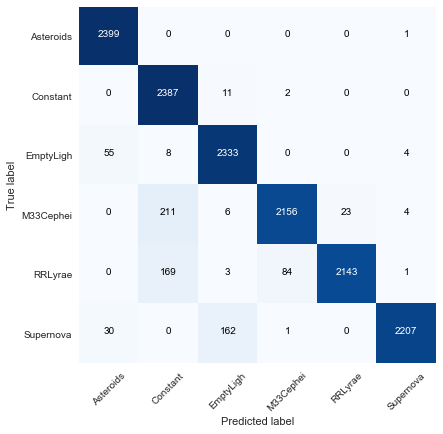

In [35]:
cm_rcnn_2 = compute_confusion_matrix(mod_rcnn_2, x_test_rcnn, y_test)
plot_confusion_matrix(cm_rcnn_2, classes=['Asteroids', 'Constant', 'EmptyLigh', 'M33Cephei', 'RRLyrae', 'Supernova'])

#### Version 3: Bidirectional LSTM, data augmentation

In [37]:
# Build augmented dataset
x_aug, y = build_dataset(scale_images(images), labels, augment=True)
x_train_aug, x_test_aug, y_train, y_test = train_test_split(x_aug, y, test_size=0.2, random_state=209, stratify=y)

In [39]:
mod_rcnn_3 = keras.models.load_model('saved_models/rcnn_aug_ep140.hdf5')
print('Test accuracy: ', mod_rcnn_3.evaluate(x_test_rcnn, y_test)[1])

14400/14400 [==============================] - 454s 32ms/step
Test accuracy:  0.9673611111111111


Confusion matrix, without normalization


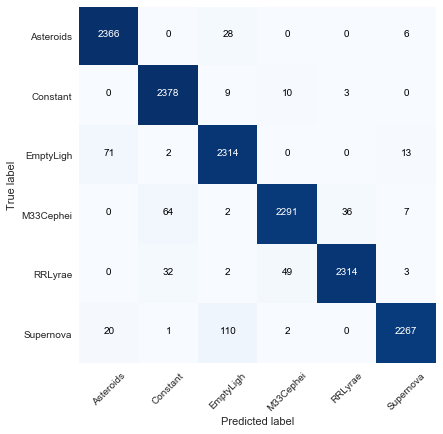

In [40]:
cm_rcnn_3 = compute_confusion_matrix(mod_rcnn_3, x_test_rcnn, y_test)
plot_confusion_matrix(cm_rcnn_3, classes=['Asteroids', 'Constant', 'EmptyLigh', 'M33Cephei', 'RRLyrae', 'Supernova'])

#### Version 4: Bidirectional LSTM, data augmentation, attention

### Effect of Dropout and Batch Normalization

In [46]:
mod_rcnn_bn = init_rcnn(bidir=True, batch_norm=True)
mod_rcnn_bn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Masking (TimeDistributed)    (None, 48, 21, 21, 1)     0         
_________________________________________________________________
Conv2D_1 (TimeDistributed)   (None, 48, 21, 21, 48)    816       
_________________________________________________________________
MaxPooling2D_1 (TimeDistribu (None, 48, 19, 19, 48)    0         
_________________________________________________________________
Conv2D_2 (TimeDistributed)   (None, 48, 19, 19, 24)    10392     
_________________________________________________________________
MaxPooling2D_2 (TimeDistribu (None, 48, 17, 17, 24)    0         
_________________________________________________________________
Conv2D_3 (TimeDistributed)   (None, 48, 17, 17, 12)    2604      
_________________________________________________________________
BatchNorm (TimeDistributed)  (None, 48, 17, 17, 12)    48        
__________

In [47]:
mod_rcnn_bn = keras.models.load_model('saved_models/batchnorm_best.hdf5')
print('Test accuracy: ', mod_rcnn_bn.evaluate(x_test_rcnn, y_test)[1])

TypeError: ('Keyword argument not understood:', 'data_format')

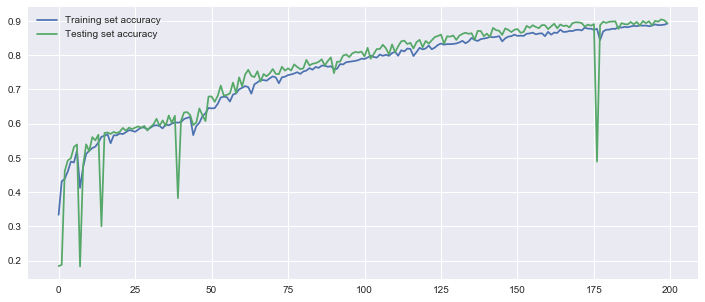

In [48]:
with open('saved_history/batch_norm/batch_norm_history.json', 'r') as f:
    hist_ep100 = json.load(f)
with open('saved_history/batch_norm/batch_norm_history_1.json', 'r') as f:
    hist_ep200 = json.load(f)
    
plt.figure(figsize=(12,5))
plt.plot(range(len(hist_ep100['acc']+hist_ep200['acc'])),\
         hist_ep100['acc']+hist_ep200['acc'], label='Training set accuracy')
plt.plot(range(len(hist_ep100['acc']+hist_ep200['acc'])), \
         hist_ep100['val_acc']+hist_ep200['val_acc'], label='Testing set accuracy')
plt.legend()